In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from keras_tqdm import TQDMNotebookCallback
from matplotlib import rc
rc("font", family="serif", size=14)
from datetime import datetime

Using TensorFlow backend.


In [116]:
data=np.genfromtxt('grid_0_0.csv', delimiter=',', skip_header=1)
print(open('grid_0_0.csv', 'r').read().split('\n')[0].split(','))

evo_tracks=[]
last_number=-1
last_index=0
for i,entry in enumerate(data):
    if entry[0]<last_number:
        evo_tracks.append(data[last_index:i])
        last_index=i
    if i==len(data)-1:
        evo_tracks.append(data[last_index:])
    last_number=entry[0]

range_tracks=[]
for track in evo_tracks:
    range_track=[]
    for entry in track:
        if entry[3]>=1 and entry[3]<=8:
            range_track.append(entry)
    if len(range_track)>0:
        range_tracks.append(np.array(range_track))
range_tracks=np.array(range_tracks)

['', 'model_number', 'star_mass', 'star_age', 'star_feh', 'star_MLT', 'star_fov', 'effective_T', 'luminosity', 'radius', 'log_g', 'surface_h1', 'surface_he4', 'center_h1', 'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass', 'delta_nu', 'delta_Pg', 'nu_max', 'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15']


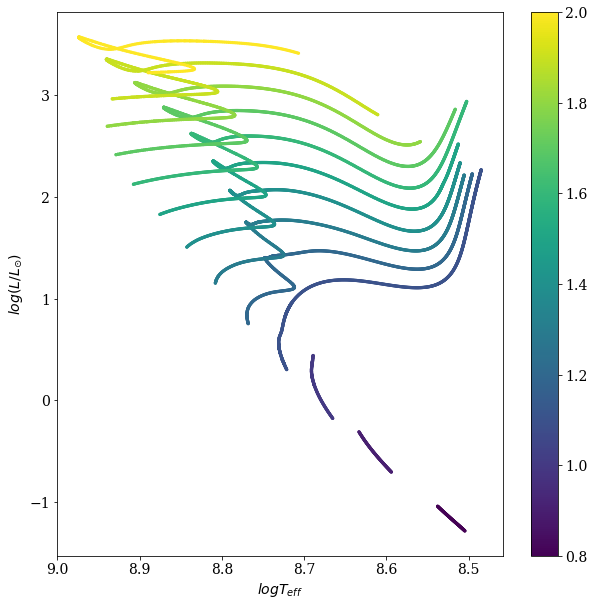

In [117]:
rc("font", family="serif", size=14)

def datatoplot(tracks):
    plot_tracks=[tracks[0][:,7],tracks[0][:,8]]
    plot_m=[tracks[0][:,2]]
    for track in tracks:
        plot_tracks[0]=np.append(plot_tracks[0],track[:,7])
        plot_tracks[1]=np.append(plot_tracks[1],track[:,8])
        plot_m=np.append(plot_m,track[:,2])
    return plot_tracks, plot_m

plot_tracks,plot_m=datatoplot(range_tracks)
fig, ax=plt.subplots(1,1,figsize=[10,10])
#print(np.ones(10)*np.array([1,2]))
s1=ax.scatter(np.log(plot_tracks[0]),np.log(plot_tracks[1]),s=5,c=plot_m,cmap='viridis')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylabel(r'$log(L/L_{\odot})$')
ax.set_xlabel(r'$log T_{eff}$')
fig.colorbar(s1)
plt.show()

In [179]:
def fetchData(data,parameters):
    indexes=[]
    for p in parameters:
        if p == 'Mass' or p == 'mass' or p == 'M':
            indexes.append(2)
        elif p == 'Age' or p == 'age':
            indexes.append(3)
        elif p == 'Metalicity' or p == 'metalicity' or p == 'Z':
            indexes.append(4)
        elif p == 'MLT':
            indexes.append(5)
        elif p == 'Teff':
            indexes.append(7)
        elif p == 'Luminosity' or p == 'luminosity' or p == 'L':
            indexes.append(8)
    return_array=[]
    if np.shape(data[0])==(27,):
        for i,ind in enumerate(indexes):
            return_array.append(np.log10(data[:,ind]).astype('float32'))
    else:
        for i,ind in enumerate(indexes):
            dummy_array=[]
            for d in data:
                dummy_array=np.append(dummy_array,np.log10(d[:,ind]).astype('float32'))
            return_array.append(dummy_array)
    return return_array

def buildModel(New_model,inout_shape=[0,0],no_layers=0,no_nodes=0,reg=None):
    if reg!=None:
        if reg[0]=='l1':
            regu=keras.regularizers.l1(reg[1])
        elif reg[0]=='l2':
            regu=keras.regularizers.l2(reg[1])
    if New_model:
        inputs=keras.Input(shape=(inout_shape[0],))
        if reg==None:
            xx=keras.layers.Dense(no_nodes,activation='relu')(inputs)
        else: xx=keras.layers.Dense(no_nodes,activation='relu',kernel_regularizer=regu)(inputs)
        for i in range(no_layers-1):
            if reg==None:
                xx=keras.layers.Dense(no_nodes,activation='relu')(xx)
            else: xx=keras.layers.Dense(no_nodes,activation='relu',kernel_regularizer=regu)(xx)
        outputs=keras.layers.Dense(inout_shape[1],activation='linear')(xx)
        model = keras.Model(inputs=inputs, outputs=outputs)
    else:
        model = keras.models.load_model('2D_model.h5')
    model.summary()
    return model

def compileModel(model, lr, loss, metrics=None, beta_1=0.9, beta_2=0.999):
    optimizer=keras.optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    if metrics!=None:
        model.compile(optimizer=optimizer,loss=loss, metrics=metrics)
    else: model.compile(optimizer=optimizer,loss=loss)

x_in=fetchData(range_tracks,['mass','age'])
y_out=fetchData(range_tracks,['L','Teff'])
m1=buildModel(True,inout_shape=[len(x_in),len(y_out)],no_layers=4,no_nodes=128)
compileModel(m1, 0.001,'MAE',metrics=['MAE','MSE'])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 258       
Total params: 50,178
Trainable params: 50,178
Non-trainable params: 0
_______________________________________________________

In [178]:
def fitModel(model, inputs, outputs, epoch_no, batch_size, save_name, keep_log=True):
    if keep_log==True:
        logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        callback=[tensorboard_callback]
    else: callback=[]

    start_time=datetime.now()
    history=model.fit(np.array(inputs).T,np.array(outputs).T,
                      epochs=epoch_no,
                      batch_size=batch_size,
                      validation_split=0.10,
                      verbose=0,
                      callbacks=callback)
    print('training done! now='+str(datetime.now())+' | Time lapsed='+str(datetime.now()-start_time))
    model.save(save_name)
    return history

hist=fitModel(m1, x_in, y_out, 10000, len(x_in[0]),'small_grid_model.h5', keep_log=False)

NameError: name 'NN1' is not defined

In [182]:
epoch_no=50000
class showProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % int(epoch_no/100) == 0:
            percent= int(np.round((epoch/int(epoch_no/100)),0))
            time=datetime.now()
            time_lapsed = (time-start_time)
            print(str(percent)+'% | epoch='+str(epoch)+'/'+str(epoch_no)+' | now='+str(time)[:-7]+
                  ' | time lapsed='+str(time_lapsed)[:-7]+' | loss='+str(np.round(logs['loss'],5)))
logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir='logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
            
start_time=datetime.now()
history=m1.fit(np.array(x_in).T,np.array(y_out).T,
                  epochs=epoch_no,
                  batch_size=len(x_in[0]),
                  validation_split=0.10,
                  verbose=0,
                  callbacks=[showProgress()])
print('training done! now='+str(datetime.now())+' | Time lapsed='+str(datetime.now()-start_time))
m1.save('small_grid_model.h5')

0% | epoch=0/50000 | now=2019-11-13 03:52:01 | time lapsed=0:00:00 | loss=0.02936
1% | epoch=500/50000 | now=2019-11-13 03:52:45 | time lapsed=0:00:44 | loss=0.03376
2% | epoch=1000/50000 | now=2019-11-13 03:53:27 | time lapsed=0:01:27 | loss=0.02535
3% | epoch=1500/50000 | now=2019-11-13 03:54:09 | time lapsed=0:02:08 | loss=0.02877
4% | epoch=2000/50000 | now=2019-11-13 03:55:06 | time lapsed=0:03:05 | loss=0.02602
5% | epoch=2500/50000 | now=2019-11-13 03:55:54 | time lapsed=0:03:53 | loss=0.01751
6% | epoch=3000/50000 | now=2019-11-13 03:56:36 | time lapsed=0:04:35 | loss=0.01915
7% | epoch=3500/50000 | now=2019-11-13 03:57:19 | time lapsed=0:05:18 | loss=0.02037
8% | epoch=4000/50000 | now=2019-11-13 03:58:04 | time lapsed=0:06:03 | loss=0.02973
9% | epoch=4500/50000 | now=2019-11-13 03:58:46 | time lapsed=0:06:45 | loss=0.01637
10% | epoch=5000/50000 | now=2019-11-13 03:59:29 | time lapsed=0:07:28 | loss=0.02231
11% | epoch=5500/50000 | now=2019-11-13 04:00:13 | time lapsed=0:08:

94% | epoch=47000/50000 | now=2019-11-13 04:58:35 | time lapsed=1:06:34 | loss=0.00785
95% | epoch=47500/50000 | now=2019-11-13 04:59:17 | time lapsed=1:07:16 | loss=0.01091
96% | epoch=48000/50000 | now=2019-11-13 04:59:58 | time lapsed=1:07:58 | loss=0.01301
97% | epoch=48500/50000 | now=2019-11-13 05:00:40 | time lapsed=1:08:39 | loss=0.01327
98% | epoch=49000/50000 | now=2019-11-13 05:01:22 | time lapsed=1:09:21 | loss=0.01446
99% | epoch=49500/50000 | now=2019-11-13 05:02:03 | time lapsed=1:10:02 | loss=0.00851
training done! now=2019-11-13 05:02:45.037850 | Time lapsed=1:10:44.109022


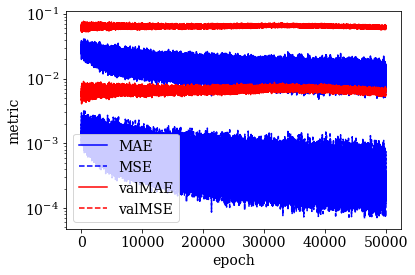

In [183]:
def plotHist(history):
    epoch = history.epoch
    hist=history.history
    MAE,MSE,valMAE,valMSE=hist['MAE'],hist['MSE'],hist['val_MAE'],hist['val_MSE']
    #MAE=hist['loss']
    plt.plot(epoch,MAE,'b-',label='MAE')
    plt.plot(epoch,MSE,'b--',label='MSE')
    plt.plot(epoch,valMAE,'r-',label='valMAE')
    plt.plot(epoch,valMSE,'r--',label='valMSE')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.legend()
    plt.show()

plotHist(history)

9211/1 - 0s


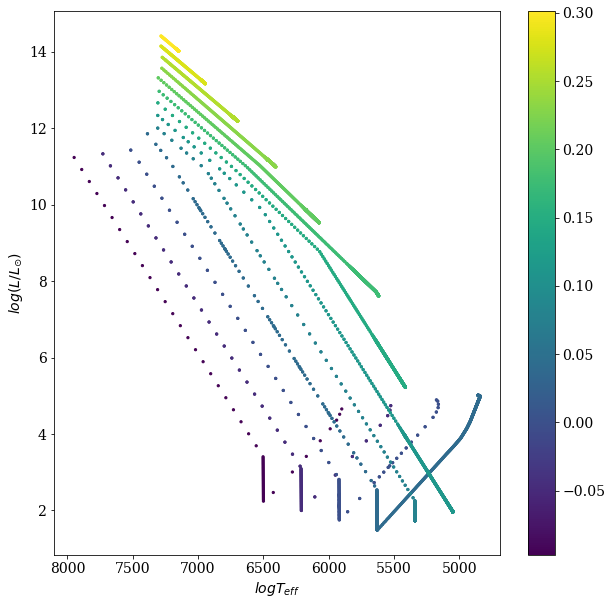

In [184]:
NN_tracks=m1.predict(np.array(x_in).T,verbose=2).T
NN_m=x_in[0]
fig, ax=plt.subplots(1,1,figsize=[10,10])
s1=ax.scatter(plot_tracks[1],plot_tracks[0],s=5,c=NN_m, cmap='viridis')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylabel(r'$log(L/L_{\odot})$')
ax.set_xlabel(r'$log T_{eff}$')
fig.colorbar(s1)
plt.show()